# Sourcepredict example2: Estimating source proportions

For this example, we'll reuse the dog, human, and soil dataset.  
But unlike [example1](https://sourcepredict.readthedocs.io/en/latest/run_example.html), here we will mix samples from different sources and estimate the mixing proportions with Sourcepredict and Sourcetracker2

## Preparing mixed samples

In [1]:
import pandas as pd
from plotnine import *
import numpy as np

In [2]:
cnt = pd.read_csv("../data/modern_gut_microbiomes_sources.csv", index_col=0)
labels = pd.read_csv("../data/modern_gut_microbiomes_labels.csv",index_col=0)

As in example 1, we'll first split the dataset into training (95%) and testing(5%)

In [3]:
cnt_train = cnt.sample(frac=0.95, axis=1)
cnt_test = cnt.drop(cnt_train.columns, axis=1)
train_labels = labels.loc[cnt_train.columns,:]
test_labels = labels.loc[cnt_test.columns,:]

In [4]:
test_labels['labels'].value_counts()

Homo_sapiens        11
Canis_familiaris     9
Soil                 2
Name: labels, dtype: int64

In [5]:
cnt_test.head()

,SRR061456,SRR1175013,SRR059395,SRR1930141,SRR1930247,SRR1761710,SRR1761700,SRR7658605,SRR7658665,SRR7658625,...,ERR1916299,ERR1914213,ERR1915363,ERR1913953,ERR1913947,ERR1916319,ERR1915204,ERR1914750,mgm4477803_3,mgm4477877_3
TAXID,,,,,,,,,,,,,,,,,,,,,
0,14825759.0,4352892.0,13691926.0,27457943.0,1212101.0,24026729.0,18876667.0,7776902.0,34166674.0,15983447.0,...,1481835.0,3254064.0,2182037.0,2225689.0,2292745.0,1549960.0,760058.0,1750182.0,5492333.0,6004642.0
6,0.0,0.0,107.0,193.0,0.0,87.0,94.0,0.0,215.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,216.0
7,0.0,0.0,107.0,193.0,0.0,87.0,94.0,0.0,215.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,216.0
9,96.0,101.0,70.0,412.0,0.0,395.0,199.0,299.0,563.0,369.0,...,62.0,63.0,110.0,59.0,63.0,51.0,0.0,61.0,0.0,0.0
10,249.0,0.0,136.0,614.0,0.0,265.0,267.0,76.0,985.0,350.0,...,66.0,174.0,0.0,74.0,73.0,62.0,0.0,66.0,0.0,0.0


We then create a function to randomly select a sample from each source (dog as $s_{dog}$ and human as $s_{human}$), and combine such as the new sample $s_{mixed} = p1*s_{dog} + p1*s_{human}$

In [6]:
def create_mixed_sample(cnt, labels, p1, samp_name):
    rand_dog = labels.query('labels == "Canis_familiaris"').sample(1).index[0]
    rand_human = labels.query('labels == "Homo_sapiens"').sample(1).index[0]
    dog_samp = cnt[rand_dog]*p1
    human_samp = cnt[rand_human]*(1-p1)
    comb = dog_samp + human_samp
    comb = comb.rename(samp_name)
    meta = pd.DataFrame({'human_sample':[rand_human],'dog_sample':[rand_dog], 'human_prop':[(1-p1)], 'dog_prop':[p1]}, index=[samp_name])
    return(comb, meta)

We run this function for a range of mixed proportions (0 to 90%, by 10%), 3 time for each mix

In [7]:
mixed_samp = []
mixed_meta = []
nb = 1
for i in range(3): 
    for p1 in np.arange(0.1,1,0.1):
        s = create_mixed_sample(cnt=cnt_test, labels=test_labels, p1=p1, samp_name=f"mixed_sample_{nb}")
        mixed_samp.append(s[0])
        mixed_meta.append(s[1])
        nb += 1

In [8]:
mixed_samples = pd.concat(mixed_samp, axis=1, keys=[s.name for s in mixed_samp]).astype(int)
mixed_samples.head()

,mixed_sample_1,mixed_sample_2,mixed_sample_3,mixed_sample_4,mixed_sample_5,mixed_sample_6,mixed_sample_7,mixed_sample_8,mixed_sample_9,mixed_sample_10,...,mixed_sample_18,mixed_sample_19,mixed_sample_20,mixed_sample_21,mixed_sample_22,mixed_sample_23,mixed_sample_24,mixed_sample_25,mixed_sample_26,mixed_sample_27
TAXID,,,,,,,,,,,,,,,,,,,,,
0,1320165,27791888,14189886,14720060,18710369,1414816,2910789,4518936,2282396,7217415,...,5331330,24788154,2020394,5968886,3231719,10313424,8480642,5192549,5175478,4809264
6,0,172,65,52,107,0,0,21,10,0,...,8,173,0,0,0,47,37,32,18,19
7,0,172,65,52,107,0,0,21,10,0,...,8,173,0,0,0,47,37,32,18,19
9,6,463,158,237,313,30,74,61,36,280,...,96,370,132,227,81,130,110,56,88,97
10,7,802,239,159,579,37,51,86,34,68,...,183,552,113,73,24,166,144,84,106,127


In [9]:
mixed_metadata = pd.concat(mixed_meta)
mixed_metadata.head()

,human_sample,dog_sample,human_prop,dog_prop
mixed_sample_1,SRR1930247,ERR1913947,0.9,0.1
mixed_sample_2,SRR7658665,ERR1913947,0.8,0.2
mixed_sample_3,SRR1761700,ERR1914213,0.7,0.3
mixed_sample_4,SRR1761710,ERR1915204,0.6,0.4
mixed_sample_5,SRR7658665,ERR1914213,0.5,0.5


Now we can export the new "test" (sink) table to `csv` for sourcepredict

In [10]:
mixed_samples.to_csv('mixed_samples_cnt.csv')

As well as the source count and labels table for the sources

In [11]:
train_labels.to_csv('train_labels.csv')
cnt_train.to_csv('sources_cnt.csv')

## Sourcepredict

For running Sourcepredict, we'll change two parameters from their default values:
- `-me` The default method used by Sourcepredict is T-SNE which a non-linear type of embedding, i.e. the distance between points doesn't reflext their actual distance in the original dimensions, to achieve a better clustering, which is good for source prediction. Because here we're more interested in source proportion estimation, rather than source prediction, we'll choose a Multi Dimensional Scaling (MDS) which is a type of linear embedding, where the distance between points in the lozer dimension match more the distances in the embedding in lower dimension, which is better for source proportion estimation.
- `-kne` which is the number of neighbors in KNN algorithm: we use a greater (50) number of neighbors to reflect more global contribution of samples to the proportion estimation, instead of only the immediate neighbors. This will affect negatively the source prediction, but give better source proportion estimations
- `-kw` which is the *weigth function* in the KNN algorithm. By defaul a **distance** based weight function is apllied to give more weigth to closer samples. However, here, we're more interested in source proportion estimation, rather than source prediction, so we'll disregard the distance based weight function and give the same weight to all neighboring samples, regardless of their distance, with the **uniform** weight function.

In [12]:
%%time
!python ../sourcepredict -s sources_cnt.csv \
               -l train_labels.csv \
               -n GMPR \
               -kne 50\
               -kw uniform \
               -me MDS \
               -e mixed_embedding.csv \
               -t 6 \
               mixed_samples_cnt.csv

Step 1: Checking for unknown proportion
  == Sample: mixed_sample_1 ==
	Adding unknown
	Normalizing (GMPR)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: mixed_sample_1
		 known:98.48%
		 unknown:1.52%
  == Sample: mixed_sample_2 ==
	Adding unknown
	Normalizing (GMPR)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 0.99
	----------------------
	- Sample: mixed_sample_2
		 known:99.73%
		 unknown:0.27%
  == Sample: mixed_sample_3 ==
	Adding unknown
	Normalizing (GMPR)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: mixed_sample_3
		 known:98.79%
		 unknown:1.21%
  == Sample: mixed_sample_

**Reading Sourcepredict results**

In [13]:
sp_ebd = pd.read_csv("mixed_embedding.csv", index_col=0)

In [14]:
sp_ebd.head()

,PC1,PC2,labels,name
SRR1761712,-3.713176,-0.344326,Homo_sapiens,SRR1761712
ERR1913614,2.586560,-0.498098,Canis_familiaris,ERR1913614
ERR1914349,-1.595982,-3.363762,Canis_familiaris,ERR1914349
SRR1930255,2.174966,-0.728862,Homo_sapiens,SRR1930255
SRR1646027,-3.329213,-0.214682,Homo_sapiens,SRR1646027


In [15]:
import warnings
warnings.filterwarnings('ignore')

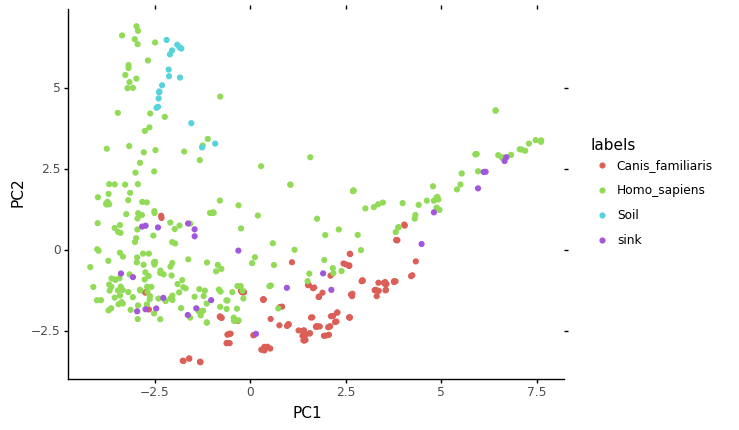

<ggplot: (-9223372029299469603)>

In [16]:
ggplot(data = sp_ebd, mapping = aes(x='PC1',y='PC2')) + geom_point(aes(color='labels')) + theme_classic()

In [17]:
sp_pred = pd.read_csv("mixed_samples_cnt.sourcepredict.csv", index_col=0)

In [18]:
sp_pred.T.head()

,Canis_familiaris,Homo_sapiens,Soil,unknown
mixed_sample_1,0.863266,0.109678,0.011905,0.015152
mixed_sample_2,0.036542,0.947680,0.013046,0.002733
mixed_sample_3,0.036198,0.938776,0.012923,0.012103
mixed_sample_4,0.055810,0.919077,0.013163,0.011951
mixed_sample_5,0.036211,0.939098,0.012927,0.011764


In [19]:
mixed_metadata.head()

,human_sample,dog_sample,human_prop,dog_prop
mixed_sample_1,SRR1930247,ERR1913947,0.9,0.1
mixed_sample_2,SRR7658665,ERR1913947,0.8,0.2
mixed_sample_3,SRR1761700,ERR1914213,0.7,0.3
mixed_sample_4,SRR1761710,ERR1915204,0.6,0.4
mixed_sample_5,SRR7658665,ERR1914213,0.5,0.5


In [20]:
sp_res = sp_pred.T.merge(mixed_metadata, left_index=True, right_index=True)

In [21]:
sp_res.head()

,Canis_familiaris,Homo_sapiens,Soil,unknown,human_sample,dog_sample,human_prop,dog_prop
mixed_sample_1,0.863266,0.109678,0.011905,0.015152,SRR1930247,ERR1913947,0.9,0.1
mixed_sample_2,0.036542,0.947680,0.013046,0.002733,SRR7658665,ERR1913947,0.8,0.2
mixed_sample_3,0.036198,0.938776,0.012923,0.012103,SRR1761700,ERR1914213,0.7,0.3
mixed_sample_4,0.055810,0.919077,0.013163,0.011951,SRR1761710,ERR1915204,0.6,0.4
mixed_sample_5,0.036211,0.939098,0.012927,0.011764,SRR7658665,ERR1914213,0.5,0.5


In [22]:
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
mse_sp = round(mean_squared_error(y_pred=sp_res['Homo_sapiens'], y_true=sp_res['human_prop']),2)

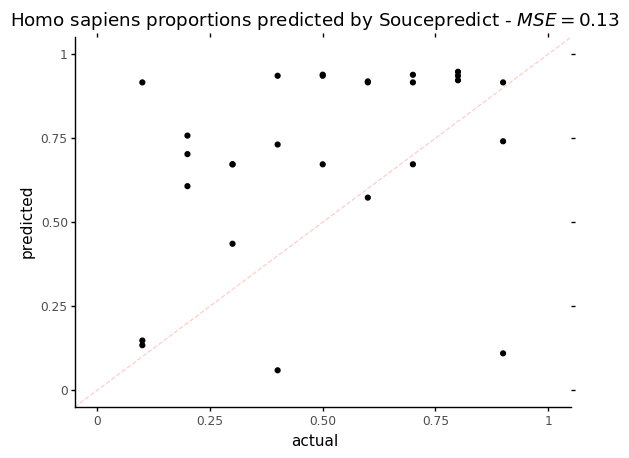

<ggplot: (-9223372036555534967)>

In [24]:
p = ggplot(data = sp_res, mapping=aes(x='human_prop',y='Homo_sapiens')) + geom_point()
p += labs(title = f"Homo sapiens proportions predicted by Soucepredict - $MSE = {mse_sp}$", x='actual', y='predicted') 
p += theme_classic() 
p += coord_cartesian(xlim=[0,1], ylim=[0,1])
p += geom_abline(intercept=0, slope=1, color = "red", alpha=0.2, linetype = 'dashed')
p

On this plot, the dotted red line represents what a perfect proportion estimation would give, with a [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) = 0.

In [25]:
sp_res_hist = (sp_res['human_prop'].append(sp_res['Homo_sapiens']).to_frame(name='Homo_sapiens_prop'))
sp_res_hist['source'] = (['actual']*sp_res.shape[0]+['predicted']*sp_res.shape[0])

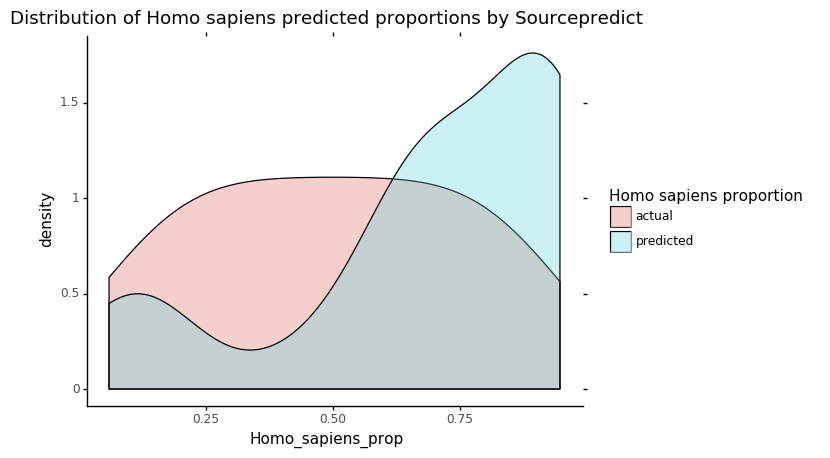

<ggplot: (-9223372029298930965)>

In [47]:
p = ggplot(data = sp_res_hist, mapping=aes(x='Homo_sapiens_prop')) + geom_density(aes(fill='source'), alpha=0.3)
p += labs(title = 'Distribution of Homo sapiens predicted proportions by Sourcepredict') 
p += scale_fill_discrete(name="Homo sapiens proportion")
p += theme_classic() 
p

This plot shows the actual and predicted by Sourcepredict distribution of Human proportions. What we are interested in is the overlap between the two colors: the higer it is, the more the estimated Human proportion is accurate.

## Sourcetracker2

Preparing count table

In [27]:
cnt_train.merge(mixed_samples, right_index=True, left_index=True).to_csv("st_mixed_count.csv" , sep="\t", index_label="TAXID")

In [28]:
!biom convert -i st_mixed_count.csv -o st_mixed_count.biom --table-type="Taxon table" --to-json

Preparing metadata

In [29]:
train_labels['SourceSink'] = ['source']*train_labels.shape[0]

In [30]:
mixed_metadata['labels'] = ['-']*mixed_metadata.shape[0]
mixed_metadata['SourceSink'] = ['sink']*mixed_metadata.shape[0]

In [31]:
st_labels = train_labels.append(mixed_metadata[['labels', 'SourceSink']])

In [32]:
st_labels = st_labels.rename(columns={'labels':'Env'})[['SourceSink','Env']]

In [33]:
st_labels.to_csv("st_mixed_labels.csv", sep="\t", index_label='#SampleID')

Running Sourcetracker2 `sourcetracker2 gibbs -i st_mixed_count.biom -m st_mixed_labels.csv -o mixed_prop --jobs 6`  
(Sourcetracker2 was run on a Linux remote server because of issues running it on MacOS)

Sourcetracker2 results

In [40]:
st_pred = pd.read_csv("mixed_prop/mixing_proportions.txt", sep="\t", index_col=0)

In [41]:
st_res = st_pred.merge(mixed_metadata, left_index=True, right_index=True)

In [42]:
mse_st = round(mean_squared_error(y_pred=st_res['Homo_sapiens'], y_true=st_res['human_prop']),2)

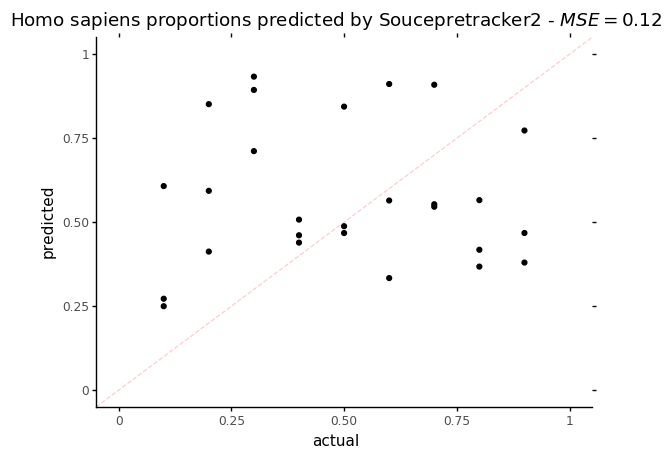

<ggplot: (-9223372029300899661)>

In [43]:
p = ggplot(data = st_res, mapping=aes(x='human_prop',y='Homo_sapiens')) + geom_point()
p += labs(title = f"Homo sapiens proportions predicted by Soucepretracker2 - $MSE = {mse_st}$", x='actual', y='predicted') 
p += theme_classic() 
p += coord_cartesian(xlim=[0,1], ylim=[0,1])
p += geom_abline(intercept=0, slope=1, color = "red", alpha=0.2, linetype = 'dashed')
p

On this plot, the dotted red line represents what a perfect proportion estimation would give, with a [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) = 0.
Regarding the MSE, Sourcepredict and Sourcetracker perform similarly with a MSE of 0.13 for Sourcepredict and 0.12 for Sourcetracker.

In [44]:
st_res_hist = (st_res['human_prop'].append(st_res['Homo_sapiens']).to_frame(name='Homo_sapiens_prop'))
st_res_hist['source'] = (['actual']*st_res.shape[0]+['predicted']*st_res.shape[0])

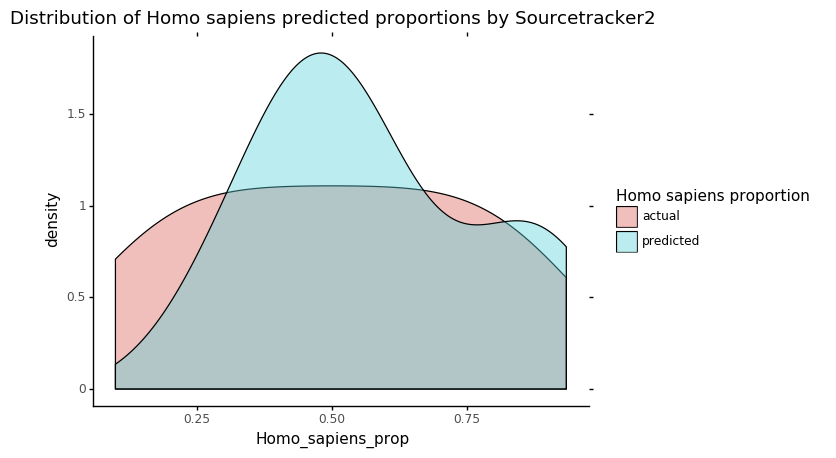

<ggplot: (7555587890)>

In [46]:
p = ggplot(data = st_res_hist, mapping=aes(x='Homo_sapiens_prop')) + geom_density(aes(fill='source'), alpha=0.4)
p += labs(title = 'Distribution of Homo sapiens predicted proportions by Sourcetracker2') 
p += scale_fill_discrete(name="Homo sapiens proportion")
p += theme_classic() 
p

This plot shows the actual and predicted by Sourcepredict distribution of Human proportions. What we are interested in is the overlap between the two colors: the higer it is, the more the estimated Human proportion is accurate.  
Here, there is a bigger overlap between actual and predicted, suggesting a slightly better source proportion estimation than with Sourcepredict.

## Conclusion
For source proportion estimation in samples of mixed sources, we've seen that Sourcepredict, with adapted parameters, can perform similarly as Sourcetracker.  
However, because Sourcepredict was designed for source prediction in mind, as opposed to source proportion estimation, it requires parameters tweaking to achive the same results as Sourcetracker.  
Therefore, for source proportion estimation, we still recommend using Sourcetracker, even if Sourcepredict can perform similarly.